In [132]:
import numpy as np
import matplotlib.pyplot as plt
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
from chainer.dataset import concat_examples
import chainer.functions as F
import chainer.links as L
import utils

In [133]:
train_data, test_data = utils.get_mnist(n_train=1000, n_test=0, with_label=False, classes = [0], n_dim=2)

In [134]:
def add_noise(h, sigma=0.5):
    xp = cuda.get_array_module(h.data)
    if chainer.config.train:
        return h + sigma * xp.random.randn(*h.shape)
    else:
        return h

In [135]:
class Discriminator(Chain):
    def __init__(self, n_out=1):
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(
                in_channels=1, out_channels=5, ksize=5, stride=1, pad=0)
            self.fc = L.Linear(None, n_out)

    def __call__(self, x):
        #h = F.relu(self.conv(x))
        h = add_noise(x)
        h = F.relu(add_noise(self.conv(x)))
        if chainer.config.train:
            return self.fc(h)
        return self.fc(h)

Discriminator network, consisting of a convolutional layer with kernel size 5, stride of 1 and 0 padding, followed by a linear readout layer of the unnormalized probabilities that an image is real or fake. 

In [136]:
class Generator(chainer.Chain):

    def __init__(self, n_hidden=10, bottom_width=26, ch=10):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch)
            self.dc0 = L.Deconvolution2D(in_channels=ch, out_channels=1, ksize=3, stride=1, pad=0)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)

    def make_hidden(self, batchsize):
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(np.float32)

    def __call__(self, x):
        h = F.reshape(F.relu(self.bn0(self.l0(x))),
                      (len(x), self.ch, self.bottom_width, self.bottom_width))
        y = F.sigmoid(self.dc0(h))
        return y

Generator network, consisting of a fully connected layer taking a random uniform vector (as seen in make_hidden) with relu activation function, utilizing batch normalization, followed by a deconvolutional layer with a sigmoid activation function. This deconvolution layer generates an image from the random input. 

In [137]:
gen = Generator()
gen_optimizer = optimizers.Adam()
gen_optimizer.setup(gen)

dis = Discriminator()
dis_optimizer = optimizers.Adam()
dis_optimizer.setup(dis)

In [138]:
batchsize = 50
max_epoch = 20
train_iter = iterators.SerialIterator(train_data, batchsize)
while train_iter.epoch < max_epoch:

    real_train = concat_examples(train_iter.next())
    real_train = np.expand_dims(real_train, axis=1)
    fake_train = gen(gen.make_hidden(batchsize))
    
    y_real = dis(real_train)
    y_fake = dis(fake_train)
    
    L1 = F.mean(F.sigmoid_cross_entropy(y_real, np.ones_like(y_real).astype(np.int32)))
    L2 = F.mean(F.sigmoid_cross_entropy(y_fake, np.zeros_like(y_fake).astype(np.int32)))
    
    dis_loss = L1 + L2 
    gen_loss = F.mean(F.sigmoid_cross_entropy(y_fake, np.ones_like(y_fake).astype(np.int32)))
    
    dis.cleargrads()
    dis_loss.backward()
    dis_optimizer.update()
    gen.cleargrads()
    gen_loss.backward()
    gen_optimizer.update()
    
    if train_iter.is_new_epoch:
        print(train_iter.epoch)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Training loop that first lets the generator network generate an image, then let's the discriminator network classify a real and a fake image. Then the sigmoid cross entropy is taken as a loss function for the discriminator as well as the generator: the discriminator's loss consists of the predictions of a real images predicted as 1 - true, and the predictions of fake images predicted as 0 - fake. The generator's loss consists of the predictions of fake images predicted as 1 - true, so as to trick the discriminator network. 

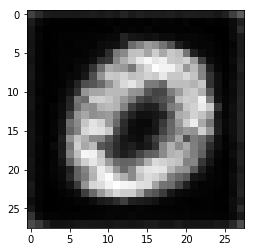

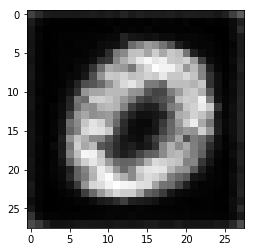

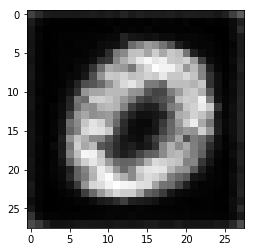

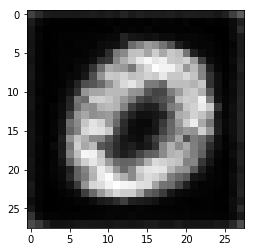

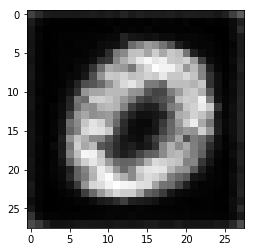

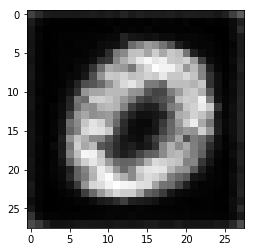

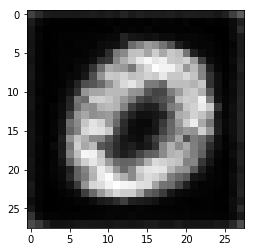

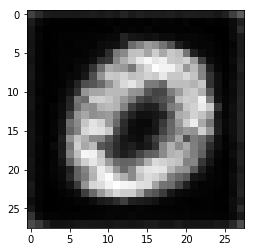

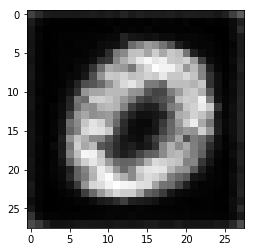

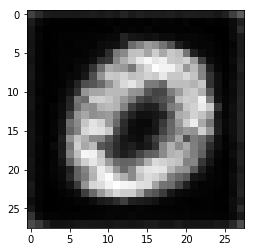

In [139]:
for i in range(10):
    y = gen.make_hidden(1)
    x = gen(y).data
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.show()

All ten generated zeros look very much alike, with only very minor differences when looking at individual pixel values. The network introduces little variation, possibly due to overfitting or lack of network depth. Adding more noise throughout the network could also bootstrap exploration instead of only exploitation as happens now. 